# 🏆 ĐỀ XUẤT CHIẾN THUẬT BÓNG ĐÁ BẰNG THUẬT TOÁN NAIVE BAYES

---

### 📌 Mục tiêu
Xây dựng mô hình học máy sử dụng **Gaussian Naive Bayes** để phân loại kết quả trận đấu (Win / Draw / Loss) dựa trên các chỉ số chiến thuật.

### 📊 Dữ liệu
- **6,928 trận đấu** từ các giải đấu hàng đầu
- **20 biến** chiến thuật và kết quả
- **3 classes**: Win, Draw, Loss

### 🗺️ Pipeline nghiên cứu
```
1. Import thư viện
2. Tải & khám phá dữ liệu
3. Phân tích & lựa chọn đặc trưng (ANOVA)
4. Chuẩn bị dữ liệu (split, scale)
5. Huấn luyện Naive Bayes
6. Đánh giá (accuracy, confusion matrix, F1)
7. Cross-validation
8. Hyperparameter tuning (Grid Search)
9. Feature importance
10. Demo dự đoán
11. Lưu mô hình
12. Tổng kết
```

---
## 📦 BLOCK 1 — Import Thư viện

**Giải thích:**
- `pandas`, `numpy`: Xử lý và tính toán dữ liệu số
- `sklearn.*`: Thư viện Machine Learning chính — chứa GaussianNB, StandardScaler, metrics…
- `scipy.stats.f_oneway`: ANOVA test để đánh giá ảnh hưởng của từng đặc trưng
- `matplotlib`, `seaborn`: Vẽ biểu đồ và visualization
- `warnings.filterwarnings('ignore')`: Tắt các cảnh báo không cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support
)

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Import thành công tất cả thư viện!")

✓ Import thành công tất cả thư viện!


---
## 📂 BLOCK 2 — Tải và Khám phá Dữ liệu

**Giải thích:**
- `pd.read_csv()`: Đọc file CSV thành DataFrame
- `df.info()`: Hiển thị kiểu dữ liệu và số lượng non-null của mỗi cột
- `df.describe()`: Thống kê mô tả (mean, std, min, max, percentiles)
- `df.isnull().sum()`: Kiểm tra giá trị thiếu — quan trọng trước khi train model

In [2]:
# Đọc dữ liệu
df = pd.read_csv('tactical_dataset_with_results.csv')

print(f"✓ Số lượng mẫu : {len(df):,}")
print(f"✓ Số lượng cột : {len(df.columns)}")
print(f"\n📋 Danh sách các cột:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

✓ Số lượng mẫu : 6,928
✓ Số lượng cột : 20

📋 Danh sách các cột:
   1. possession_ratio
   2. num_passes
   3. avg_pass_length
   4. shots
   5. xg
   6. pressures
   7. tackles
   8. interceptions
   9. avg_x_position
  10. team_width
  11. final_third_actions
  12. ppda
  13. match_id
  14. team
  15. competition
  16. season
  17. goals_for
  18. goals_against
  19. goal_diff
  20. result


In [3]:
# Xem 5 dòng đầu
print("\n📊 5 mẫu dữ liệu đầu tiên:")
df.head()


📊 5 mẫu dữ liệu đầu tiên:


,possession_ratio,num_passes,avg_pass_length,shots,xg,pressures,tackles,interceptions,avg_x_position,team_width,final_third_actions,ppda,match_id,team,competition,season,goals_for,goals_against,goal_diff,result
0,0.548188,651,17.239263,20,3.004243,220,18,7,63.809874,79.9,628,1.522449,3895302,Bayer Leverkusen,1. Bundesliga,2023/2024,5,0,5,Win
1,0.451812,521,20.402782,7,0.683733,212,34,10,49.425502,79.9,273,1.082031,3895302,Werder Bremen,1. Bundesliga,2023/2024,0,5,-5,Loss
2,0.380952,372,23.465847,9,0.545083,154,44,11,49.750242,79.9,308,1.406699,3895292,Union Berlin,1. Bundesliga,2023/2024,0,1,-1,Loss
3,0.619048,708,19.188975,20,2.563543,124,32,9,64.557318,79.9,720,1.460606,3895292,Bayer Leverkusen,1. Bundesliga,2023/2024,1,0,1,Win
4,0.547478,566,19.865822,17,1.441534,162,33,15,59.098136,79.9,460,1.266667,3895333,Eintracht Frankfurt,1. Bundesliga,2023/2024,1,5,-4,Loss


In [4]:
# Thống kê mô tả
print("\n📈 Thống kê mô tả:")
df.describe()


📈 Thống kê mô tả:


,possession_ratio,num_passes,avg_pass_length,shots,xg,pressures,tackles,interceptions,avg_x_position,team_width,final_third_actions,ppda,match_id,goals_for,goals_against,goal_diff
count,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6.928000e+03,6928.000000,6928.000000,6928.000000
mean,0.500000,488.995381,21.900457,12.705398,1.354386,160.776415,37.220121,11.495525,58.297731,79.780788,437.644630,1.278018,2.986350e+06,1.426819,1.426819,0.000000
std,0.094085,141.512346,2.265499,5.699690,0.963918,46.237492,10.933024,5.956120,5.363670,0.301537,174.469717,0.355934,1.550292e+06,1.372401,1.372401,2.112814
min,0.214849,165.000000,15.382032,0.000000,0.000000,24.000000,9.000000,0.000000,34.662976,78.000000,56.000000,0.501706,7.298000e+03,0.000000,0.000000,-13.000000
25%,0.433586,387.000000,20.375082,9.000000,0.677903,129.000000,29.000000,7.000000,54.982144,79.900000,319.000000,1.027142,3.749433e+06,0.000000,0.000000,-1.000000
50%,0.500000,470.000000,21.756442,12.000000,1.151381,157.000000,37.000000,11.000000,58.489714,79.900000,411.000000,1.230769,3.825668e+06,1.000000,1.000000,0.000000
75%,0.566414,574.250000,23.298961,16.000000,1.791091,188.000000,45.000000,15.000000,61.795871,79.900000,524.000000,1.464391,3.879873e+06,2.000000,2.000000,1.000000
max,0.785151,1157.000000,32.788954,46.000000,9.782631,393.000000,83.000000,42.000000,78.112325,80.300000,1569.000000,4.352941,4.020846e+06,13.000000,13.000000,13.000000


In [5]:
# Kiểm tra giá trị thiếu
print("\n🔍 Kiểm tra NULL:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "✓ Không có giá trị NULL!")

# Phân phối biến mục tiêu
print("\n🎯 Phân phối biến mục tiêu (result):")
result_counts = df['result'].value_counts()
for r, c in result_counts.items():
    print(f"  - {r:5s}: {c:,} ({c/len(df)*100:.2f}%)")


🔍 Kiểm tra NULL:
✓ Không có giá trị NULL!

🎯 Phân phối biến mục tiêu (result):
  - Win  : 2,667 (38.50%)
  - Loss : 2,667 (38.50%)
  - Draw : 1,594 (23.01%)


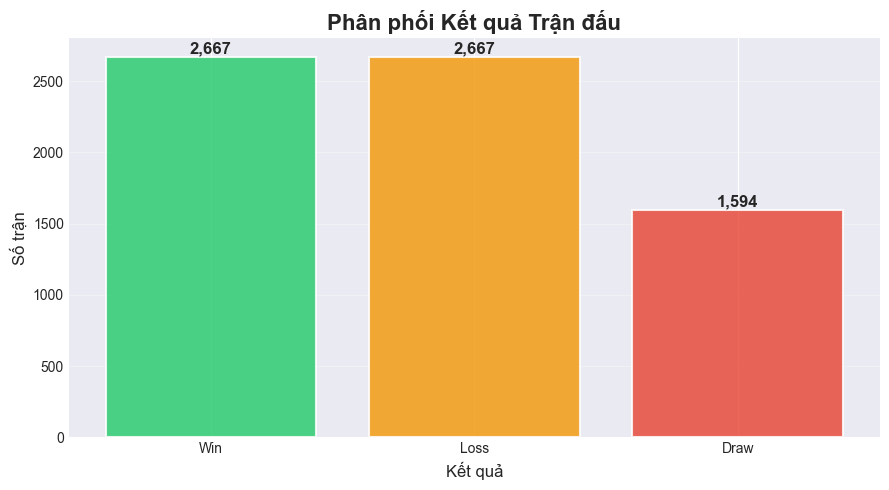

In [6]:
# Biểu đồ phân phối kết quả
plt.figure(figsize=(9, 5))
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = plt.bar(result_counts.index, result_counts.values, color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h + 30, f'{h:,}', ha='center', fontweight='bold', fontsize=12)

plt.title('Phân phối Kết quả Trận đấu', fontsize=16, fontweight='bold')
plt.xlabel('Kết quả', fontsize=12)
plt.ylabel('Số trận', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 🔬 BLOCK 3 — Phân tích và Lựa chọn Đặc trưng

**Giải thích — ANOVA Test (F-statistic):**
- Kiểm định xem giá trị trung bình của một đặc trưng có **khác nhau đáng kể** giữa 3 nhóm Win/Draw/Loss không
- **F-statistic lớn** → đặc trưng phân biệt tốt giữa các class → nên chọn
- **p-value < 0.001** → sự khác biệt có ý nghĩa thống kê rất cao
- Sau đó kiểm tra thêm **tương quan (Pearson r)** để tránh đa cộng tuyến

**Naive Bayes và đa cộng tuyến:**
> Naive Bayes giả định các đặc trưng **độc lập có điều kiện**. Nếu hai đặc trưng tương quan cao (|r|>0.7), thông tin bị tính hai lần → nên loại bỏ một trong hai.

In [7]:
# Tất cả đặc trưng số cần xét
numerical_features = [
    'possession_ratio', 'num_passes', 'avg_pass_length', 'shots', 'xg',
    'pressures', 'tackles', 'interceptions', 'avg_x_position',
    'team_width', 'final_third_actions', 'ppda'
]

print("ANOVA TEST — Mức độ ảnh hưởng của từng đặc trưng lên kết quả trận đấu")
print("="*80)

anova_results = []
for feat in numerical_features:
    win  = df[df['result']=='Win'][feat]
    draw = df[df['result']=='Draw'][feat]
    loss = df[df['result']=='Loss'][feat]
    f_stat, p_val = f_oneway(win, draw, loss)
    anova_results.append({'feature': feat, 'f_stat': f_stat, 'p_value': p_val,
                          'win_mean': win.mean(), 'draw_mean': draw.mean(), 'loss_mean': loss.mean()})

anova_df = pd.DataFrame(anova_results).sort_values('f_stat', ascending=False)

print(f"\n{'Đặc trưng':<25s} {'F-stat':>8s}  {'p-value':>10s}  {'Win μ':>8s}  {'Draw μ':>8s}  {'Loss μ':>8s}")
print("-"*80)
for _, row in anova_df.iterrows():
    flag = "✅" if row['p_value'] < 0.001 else ("⚠️ " if row['p_value'] < 0.05 else "❌")
    print(f"{row['feature']:<25s} {row['f_stat']:>8.1f}  {row['p_value']:>10.6f}  "
          f"{row['win_mean']:>8.3f}  {row['draw_mean']:>8.3f}  {row['loss_mean']:>8.3f}  {flag}")

ANOVA TEST — Mức độ ảnh hưởng của từng đặc trưng lên kết quả trận đấu

Đặc trưng                   F-stat     p-value     Win μ    Draw μ    Loss μ
--------------------------------------------------------------------------------
xg                           738.6    0.000000     1.815     1.354     0.894  ✅
shots                        383.4    0.000000    14.753    12.718    10.651  ✅
possession_ratio             338.8    0.000000     0.532     0.500     0.468  ✅
num_passes                   272.5    0.000000   534.019   483.671   447.154  ✅
final_third_actions          248.9    0.000000   488.009   441.244   385.129  ✅
avg_x_position               183.8    0.000000    59.585    58.551    56.859  ✅
avg_pass_length              101.2    0.000000    21.418    22.205    22.201  ✅
pressures                     87.2    0.000000   152.615   160.457   169.129  ✅
tackles                       50.2    0.000000    35.798    39.205    37.456  ✅
team_width                    12.4    0.000004    7

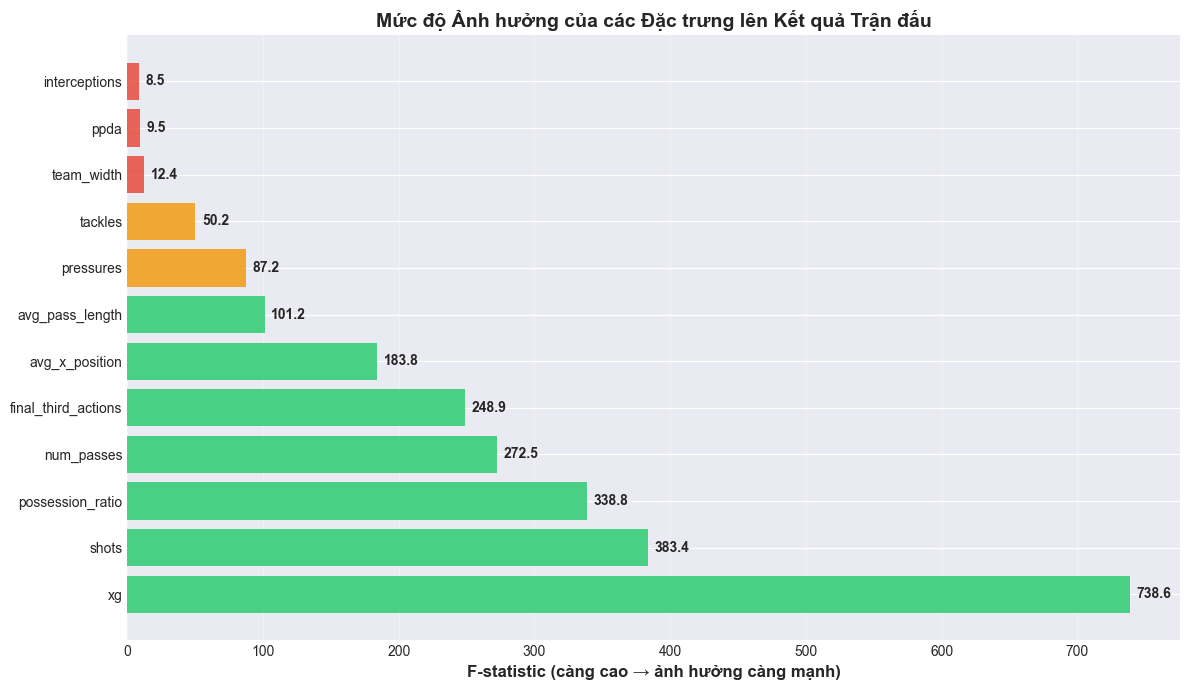

In [8]:
# Biểu đồ F-statistic
plt.figure(figsize=(12, 7))
colors_bar = ['#2ecc71' if v > 100 else ('#f39c12' if v > 30 else '#e74c3c')
              for v in anova_df['f_stat']]
bars = plt.barh(anova_df['feature'], anova_df['f_stat'], color=colors_bar, alpha=0.85)
plt.xlabel('F-statistic (càng cao → ảnh hưởng càng mạnh)', fontsize=12, fontweight='bold')
plt.title('Mức độ Ảnh hưởng của các Đặc trưng lên Kết quả Trận đấu', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
for bar, val in zip(bars, anova_df['f_stat']):
    plt.text(val + 5, bar.get_y() + bar.get_height()/2, f'{val:.1f}', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

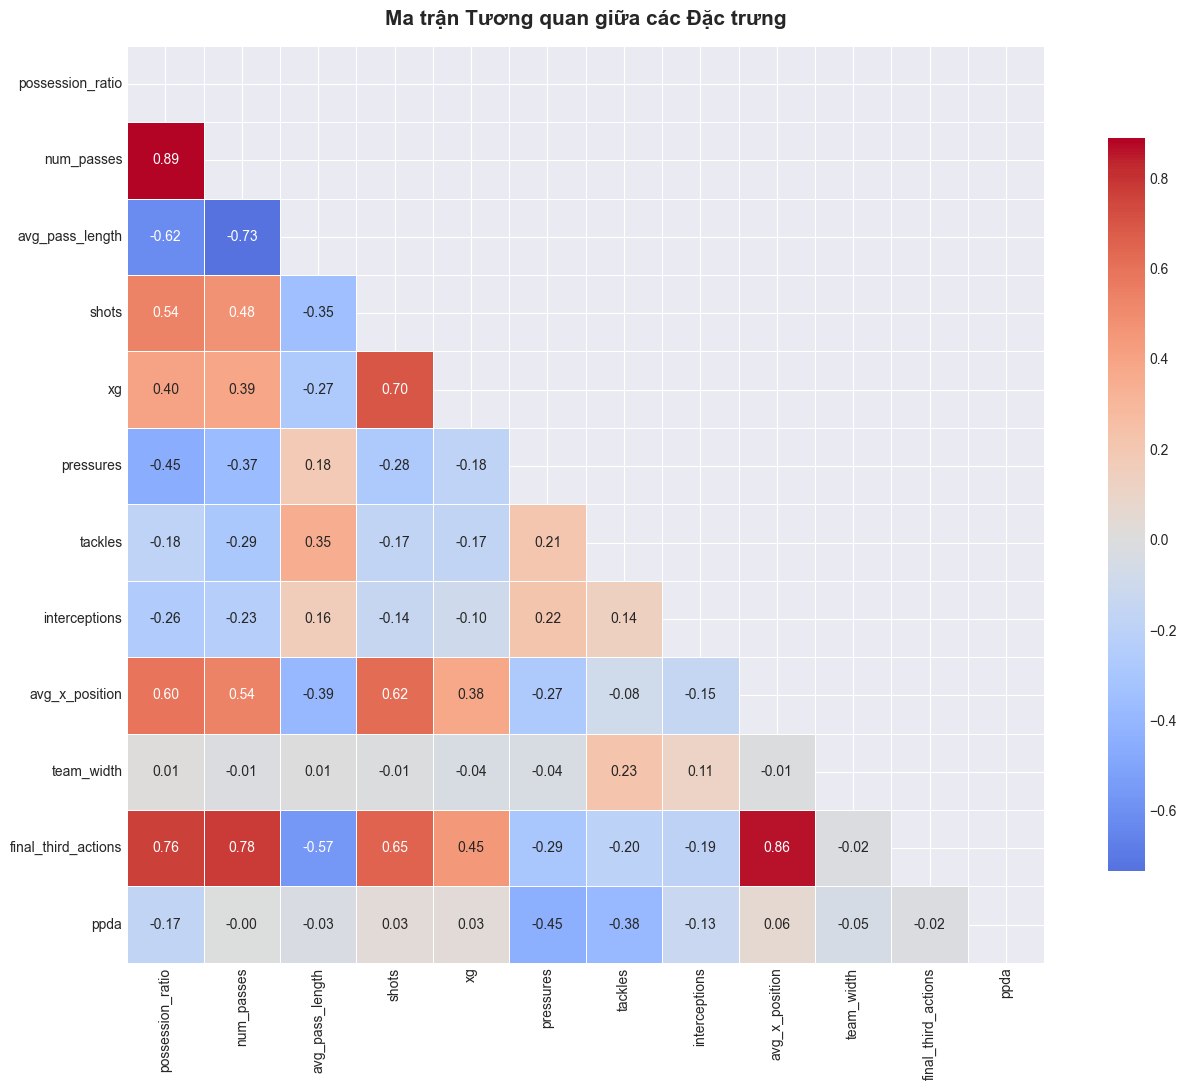


⚠️  Các cặp tương quan cao (|r| > 0.7) — nên chọn 1 trong 2:
  • possession_ratio          <-> num_passes                 r = +0.890
  • possession_ratio          <-> final_third_actions        r = +0.763
  • num_passes                <-> avg_pass_length            r = -0.733
  • num_passes                <-> final_third_actions        r = +0.777
  • avg_x_position            <-> final_third_actions        r = +0.863


In [9]:
# Ma trận tương quan toàn bộ đặc trưng
plt.figure(figsize=(14, 11))
corr = df[numerical_features].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True          # Ẩn nửa trên (đối xứng)
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Ma trận Tương quan giữa các Đặc trưng', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\n⚠️  Các cặp tương quan cao (|r| > 0.7) — nên chọn 1 trong 2:")
for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        r = corr.iloc[i, j]
        if abs(r) > 0.7:
            print(f"  • {numerical_features[i]:25s} <-> {numerical_features[j]:25s}  r = {r:+.3f}")

In [10]:
# ===== LỰA CHỌN ĐẶC TRƯNG TỐI ƯU =====
# Tiêu chí: (1) F-stat cao, (2) p<0.001, (3) Không tương quan cao với biến khác đã chọn

optimal_features = [
    'xg',               # F=738 — Quan trọng nhất, xác suất ghi bàn thực tế
    'shots',            # F=383 — Số cú sút phản ánh sức tấn công
    'possession_ratio', # F=339 — Kiểm soát bóng cơ bản
    'avg_x_position',   # F=184 — Vị trí TB: cao=tấn công, thấp=phòng thủ
    'pressures',        # F=87  — Áp lực phòng thủ phải chịu (ngược chiều Win)
    'tackles',          # F=50  — Số pha tranh chấp (bổ sung góc phòng thủ)
    'avg_pass_length',  # F=101 — Phong cách (ngắn=kiểm soát, dài=phản công)
]

excluded = {
    'num_passes':           'r=0.89 với possession_ratio → thông tin trùng lặp',
    'final_third_actions':  'r>0.76 với nhiều biến → đa cộng tuyến nặng',
    'team_width':           'std~0.3 → gần như không thay đổi → vô nghĩa',
    'interceptions':        'F=8.5  → ảnh hưởng quá yếu',
    'ppda':                 'F=9.5  → ảnh hưởng yếu nhất',
}

print("✅ Đặc trưng ĐÃ CHỌN:")
for i, f in enumerate(optimal_features, 1):
    row = anova_df[anova_df['feature'] == f].iloc[0]
    print(f"  {i}. {f:<22s}  F={row['f_stat']:>6.1f}")

print("\n❌ Đặc trưng BỊ LOẠI:")
for f, reason in excluded.items():
    print(f"  • {f:<22s}  {reason}")

✅ Đặc trưng ĐÃ CHỌN:
  1. xg                      F= 738.6
  2. shots                   F= 383.4
  3. possession_ratio        F= 338.8
  4. avg_x_position          F= 183.8
  5. pressures               F=  87.2
  6. tackles                 F=  50.2
  7. avg_pass_length         F= 101.2

❌ Đặc trưng BỊ LOẠI:
  • num_passes              r=0.89 với possession_ratio → thông tin trùng lặp
  • final_third_actions     r>0.76 với nhiều biến → đa cộng tuyến nặng
  • team_width              std~0.3 → gần như không thay đổi → vô nghĩa
  • interceptions           F=8.5  → ảnh hưởng quá yếu
  • ppda                    F=9.5  → ảnh hưởng yếu nhất


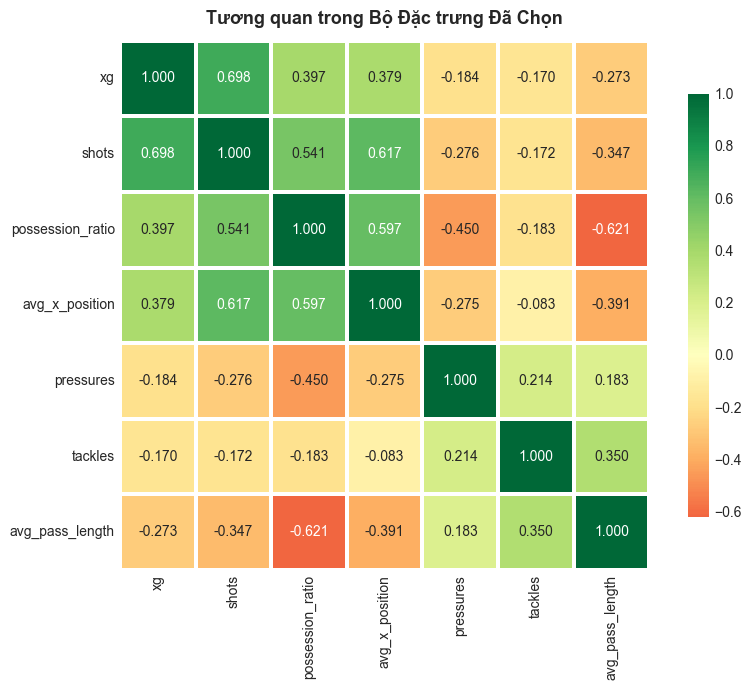

✅ Không có cặp nào |r| > 0.7 → phù hợp với giả định Naive Bayes!


In [11]:
# Kiểm tra lại tương quan trong bộ 7 đặc trưng đã chọn
selected_corr = df[optimal_features].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(selected_corr, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, square=True, linewidths=1.5, cbar_kws={'shrink': 0.8})
plt.title('Tương quan trong Bộ Đặc trưng Đã Chọn', fontsize=13, fontweight='bold', pad=12)
plt.tight_layout()
plt.show()

has_high_corr = any(abs(selected_corr.iloc[i, j]) > 0.7
                    for i in range(len(optimal_features))
                    for j in range(i+1, len(optimal_features)))
print("✅ Không có cặp nào |r| > 0.7 → phù hợp với giả định Naive Bayes!" if not has_high_corr
      else "⚠️  Vẫn còn tương quan cao!")

---
## ✂️ BLOCK 4 — Chuẩn bị Dữ liệu

**Giải thích từng bước:**

| Bước | Hành động | Lý do |
|------|-----------|-------|
| **1. Tách X, y** | X = features, y = target | Cấu trúc chuẩn cho sklearn |
| **2. train_test_split** | 80% train, 20% test | Train để học, test để đánh giá khách quan |
| **stratify=y** | Phân phối class đồng đều | Tránh test set toàn Win hoặc toàn Loss |
| **3. StandardScaler** | Mean=0, Std=1 | GaussianNB dùng phân phối chuẩn, scale ảnh hưởng kết quả |
| **fit trên train only** | `fit_transform(X_train)` | Không để test set "nhìn" vào quá trình chuẩn hóa → tránh data leakage |

In [12]:
# Bước 1: Tách X (features) và y (target)
X = df[optimal_features].values
y = df['result'].values

print(f"✓ X (features): {X.shape[0]:,} mẫu × {X.shape[1]} đặc trưng")
print(f"✓ y (target)  : {y.shape[0]:,} mẫu")

✓ X (features): 6,928 mẫu × 7 đặc trưng
✓ y (target)  : 6,928 mẫu


In [13]:
# Bước 2: Chia Train / Test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% dành cho test
    random_state=42,     # Seed để tái tạo kết quả
    stratify=y           # Giữ tỷ lệ Win/Draw/Loss đồng đều
)

print(f"✓ Train set : {len(X_train):,} mẫu (80%)")
print(f"✓ Test set  : {len(X_test):,}  mẫu (20%)")
print(f"\n📊 Phân phối trong Train set:")
for r, pct in pd.Series(y_train).value_counts(normalize=True).items():
    print(f"  - {r}: {pct*100:.2f}%")
print(f"\n📊 Phân phối trong Test set:")
for r, pct in pd.Series(y_test).value_counts(normalize=True).items():
    print(f"  - {r}: {pct*100:.2f}%")

✓ Train set : 5,542 mẫu (80%)
✓ Test set  : 1,386  mẫu (20%)

📊 Phân phối trong Train set:
  - Win: 38.51%
  - Loss: 38.49%
  - Draw: 23.01%

📊 Phân phối trong Test set:
  - Loss: 38.53%
  - Win: 38.46%
  - Draw: 23.02%


In [14]:
# Bước 3: Chuẩn hóa dữ liệu (StandardScaler)
# QUAN TRỌNG: Chỉ fit() trên train set, sau đó transform() cả train lẫn test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # học mean/std TỪ train
X_test_scaled  = scaler.transform(X_test)        # áp dụng cùng mean/std lên test

print("✓ Chuẩn hóa hoàn thành!")
print(f"  Train — mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")
print(f"  Test  — mean: {X_test_scaled.mean():.4f},  std: {X_test_scaled.std():.4f}")

# So sánh trước/sau chuẩn hóa (đặc trưng xg)
print(f"\n  xG trước chuẩn hóa: min={X_train[:,0].min():.2f}, max={X_train[:,0].max():.2f}")
print(f"  xG sau  chuẩn hóa: min={X_train_scaled[:,0].min():.2f}, max={X_train_scaled[:,0].max():.2f}")

✓ Chuẩn hóa hoàn thành!
  Train — mean: -0.000000, std: 1.000000
  Test  — mean: 0.0080,  std: 0.9727

  xG trước chuẩn hóa: min=0.00, max=9.78
  xG sau  chuẩn hóa: min=-1.39, max=8.63


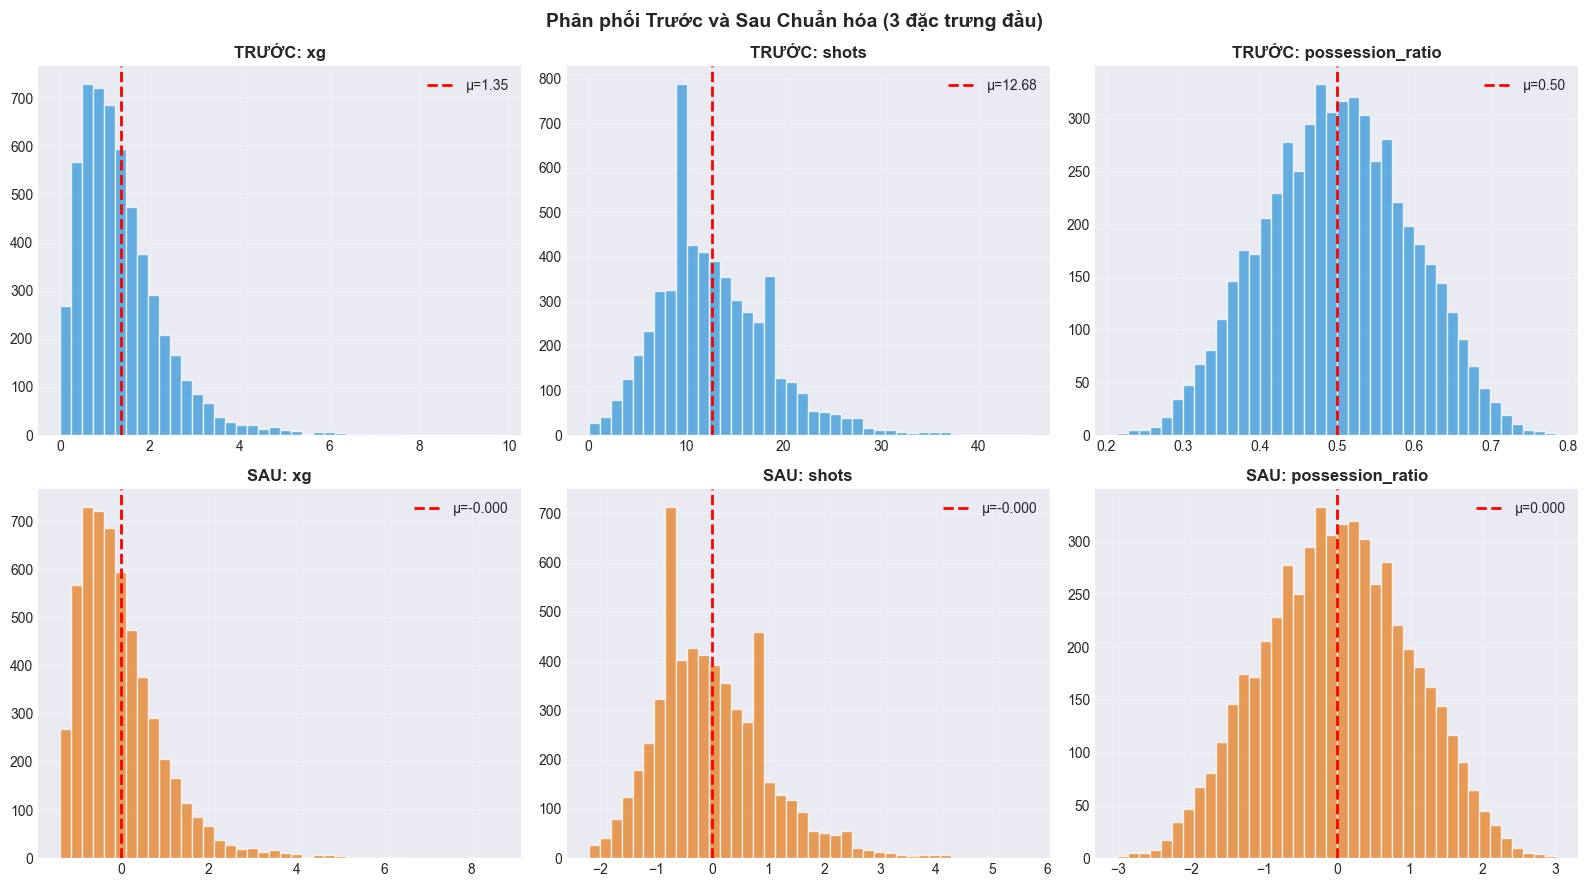

In [15]:
# Visualization: so sánh phân phối trước/sau chuẩn hóa (3 đặc trưng)
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Phân phối Trước và Sau Chuẩn hóa (3 đặc trưng đầu)', fontsize=14, fontweight='bold')

for idx in range(3):
    # Trước
    axes[0, idx].hist(X_train[:, idx], bins=40, color='#3498db', alpha=0.75, edgecolor='white')
    axes[0, idx].set_title(f'TRƯỚC: {optimal_features[idx]}', fontweight='bold')
    axes[0, idx].axvline(X_train[:, idx].mean(), color='red', linestyle='--', lw=2,
                          label=f'μ={X_train[:, idx].mean():.2f}')
    axes[0, idx].legend(); axes[0, idx].grid(alpha=0.3)
    # Sau
    axes[1, idx].hist(X_train_scaled[:, idx], bins=40, color='#e67e22', alpha=0.75, edgecolor='white')
    axes[1, idx].set_title(f'SAU: {optimal_features[idx]}', fontweight='bold')
    axes[1, idx].axvline(X_train_scaled[:, idx].mean(), color='red', linestyle='--', lw=2,
                          label=f'μ={X_train_scaled[:, idx].mean():.3f}')
    axes[1, idx].legend(); axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 🤖 BLOCK 5 — Huấn luyện Mô hình Naive Bayes

**Nguyên lý Gaussian Naive Bayes:**

$$P(y \mid X) \propto P(y) \times \prod_{i=1}^{n} P(x_i \mid y)$$

Trong đó với mỗi đặc trưng $x_i$ và mỗi class $y$:

$$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma_y^2}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right)$$

**Các bước mô hình học từ dữ liệu:**
1. Tính **Prior** P(y): tỷ lệ từng class trong train set
2. Tính **Mean** μ: mean của mỗi đặc trưng trong mỗi class  
3. Tính **Variance** σ²: variance của mỗi đặc trưng trong mỗi class  
4. Khi dự đoán: tính xác suất theo công thức trên, chọn class có P cao nhất

In [16]:
# Khởi tạo và huấn luyện
model = GaussianNB(var_smoothing=1e-9)  # var_smoothing: thêm epsilon vào variance tránh chia 0
model.fit(X_train_scaled, y_train)

print("✓ Đã huấn luyện Gaussian Naive Bayes!")
print(f"\n📋 Thông tin các Class đã học:")
for cls in model.classes_:
    n = np.sum(y_train == cls)
    print(f"  - {cls:5s}: {n:,} mẫu ({n/len(y_train)*100:.2f}%)")

✓ Đã huấn luyện Gaussian Naive Bayes!

📋 Thông tin các Class đã học:
  - Draw : 1,275 mẫu (23.01%)
  - Loss : 2,133 mẫu (38.49%)
  - Win  : 2,134 mẫu (38.51%)


In [17]:
# Xem những gì mô hình đã học (Mean và Variance của từng đặc trưng theo class)
print("📊 Mean (μ) mà mô hình học được — giá trị đã được chuẩn hóa:")
print(f"\n{'Class':<7s}", end="")
for f in optimal_features:
    print(f"{f[:9]:>11s}", end="")
print()
print("-" * 85)

for idx, cls in enumerate(model.classes_):
    direction = {"Win": "↑ tấn công", "Loss": "↓ phòng thủ", "Draw": "≈ trung bình"}
    print(f"{cls:<7s}", end="")
    for j in range(len(optimal_features)):
        print(f"{model.theta_[idx, j]:>11.3f}", end="")
    print(f"   [{direction[cls]}]")

print("\n💡 Win có mean dương (↑) ở xG, shots, possession — âm (↓) ở pressures, tackles")
print("💡 Loss có pattern ngược lại")
print("💡 Draw nằm giữa → khó phân biệt")

📊 Mean (μ) mà mô hình học được — giá trị đã được chuẩn hóa:

Class           xg      shots  possessio  avg_x_pos  pressures    tackles  avg_pass_
-------------------------------------------------------------------------------------
Draw        -0.003     -0.010     -0.017      0.039     -0.000      0.176      0.151   [≈ trung bình]
Loss        -0.474     -0.356     -0.341     -0.273      0.164      0.017      0.131   [↓ phòng thủ]
Win          0.476      0.362      0.351      0.249     -0.164     -0.122     -0.221   [↑ tấn công]

💡 Win có mean dương (↑) ở xG, shots, possession — âm (↓) ở pressures, tackles
💡 Loss có pattern ngược lại
💡 Draw nằm giữa → khó phân biệt


---
## 📊 BLOCK 6 — Đánh giá Mô hình

**Các metrics đánh giá:**

| Metric | Công thức | Ý nghĩa |
|--------|-----------|---------|
| **Accuracy** | TP+TN / Total | % dự đoán đúng tổng thể |
| **Precision** | TP / (TP+FP) | Trong số dự đoán là X, bao nhiêu % thực sự là X |
| **Recall** | TP / (TP+FN) | Trong số thực tế là X, bao nhiêu % được phát hiện |
| **F1-score** | 2 × (P×R)/(P+R) | Trung bình điều hòa — cân bằng Precision và Recall |

In [18]:
# Dự đoán trên Train và Test
y_train_pred = model.predict(X_train_scaled)
y_test_pred  = model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print(f"{'Tập dữ liệu':<15s}  {'Accuracy':>10s}")
print("-" * 30)
print(f"{'Train set':<15s}  {train_acc*100:>9.2f}%")
print(f"{'Test set':<15s}  {test_acc*100:>9.2f}%")
print(f"{'Chênh lệch':<15s}  {abs(train_acc-test_acc)*100:>9.2f}%")

gap = abs(train_acc - test_acc)
if gap < 0.05:
    print("\n✅ Mô hình RẤT ỔN ĐỊNH — không overfitting (chênh lệch < 5%)")
elif gap < 0.1:
    print("\n✓  Mô hình ổn định (chênh lệch < 10%)")
else:
    print("\n⚠️  Có dấu hiệu overfitting!")

Tập dữ liệu        Accuracy
------------------------------
Train set            54.13%
Test set             54.69%
Chênh lệch            0.56%

✅ Mô hình RẤT ỔN ĐỊNH — không overfitting (chênh lệch < 5%)


In [19]:
# Classification Report chi tiết
print("CLASSIFICATION REPORT (Test Set):")
print("=" * 55)
print(classification_report(y_test, y_test_pred, digits=4))

print("\n💡 Giải thích:")
print("  Win: F1=~0.60 — Dự đoán tốt")
print("  Loss: F1=~0.63, recall cao (~77%) — Tốt nhất, phát hiện đội thua rất tốt")
print("  Draw: F1=~0.08, recall rất thấp — Yếu nhất (Draw khó đoán do yếu tố ngẫu nhiên)")

CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

        Draw     0.4375    0.0439    0.0798       319
        Loss     0.5331    0.7697    0.6299       534
         Win     0.5712    0.6248    0.5968       533

    accuracy                         0.5469      1386
   macro avg     0.5139    0.4794    0.4355      1386
weighted avg     0.5257    0.5469    0.4905      1386


💡 Giải thích:
  Win: F1=~0.60 — Dự đoán tốt
  Loss: F1=~0.63, recall cao (~77%) — Tốt nhất, phát hiện đội thua rất tốt
  Draw: F1=~0.08, recall rất thấp — Yếu nhất (Draw khó đoán do yếu tố ngẫu nhiên)


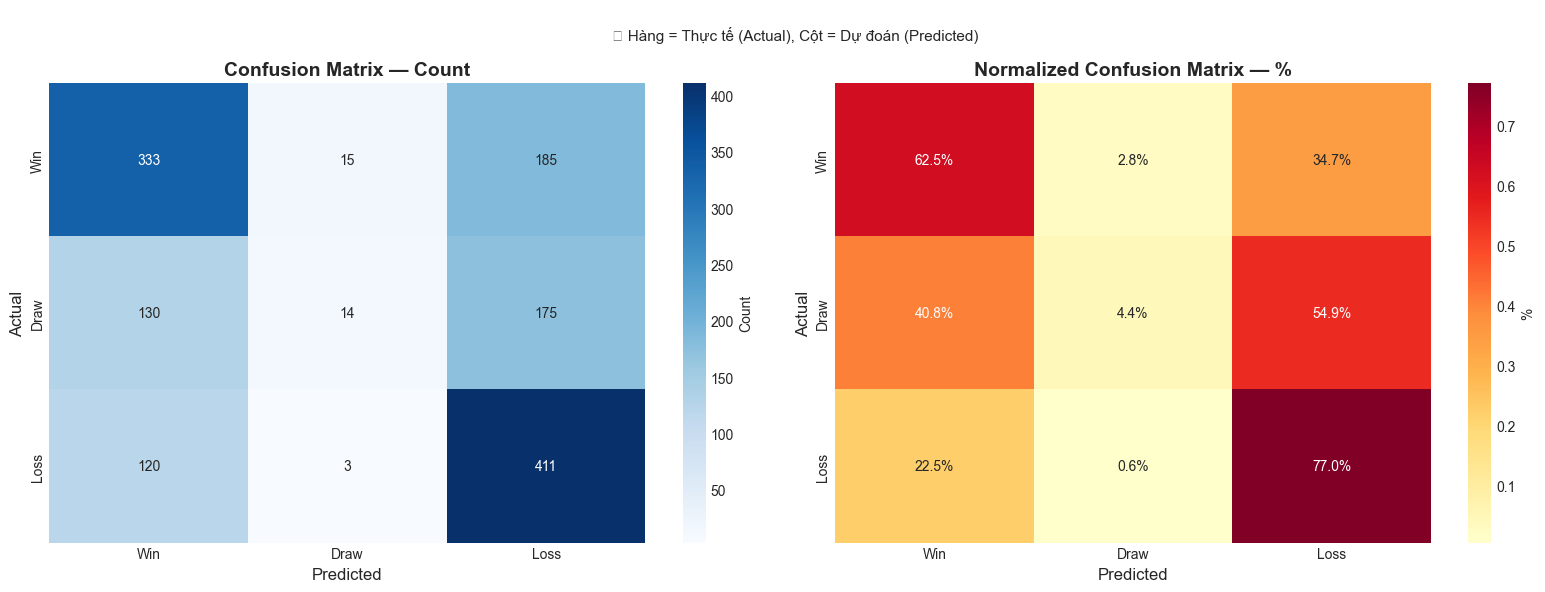

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['Win', 'Draw', 'Loss'])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Win','Draw','Loss'], yticklabels=['Win','Draw','Loss'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix — Count', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='YlOrRd',
            xticklabels=['Win','Draw','Loss'], yticklabels=['Win','Draw','Loss'],
            ax=axes[1], cbar_kws={'label': '%'})
axes[1].set_title('Normalized Confusion Matrix — %', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.suptitle('\n💡 Hàng = Thực tế (Actual), Cột = Dự đoán (Predicted)', fontsize=11)
plt.tight_layout()
plt.show()

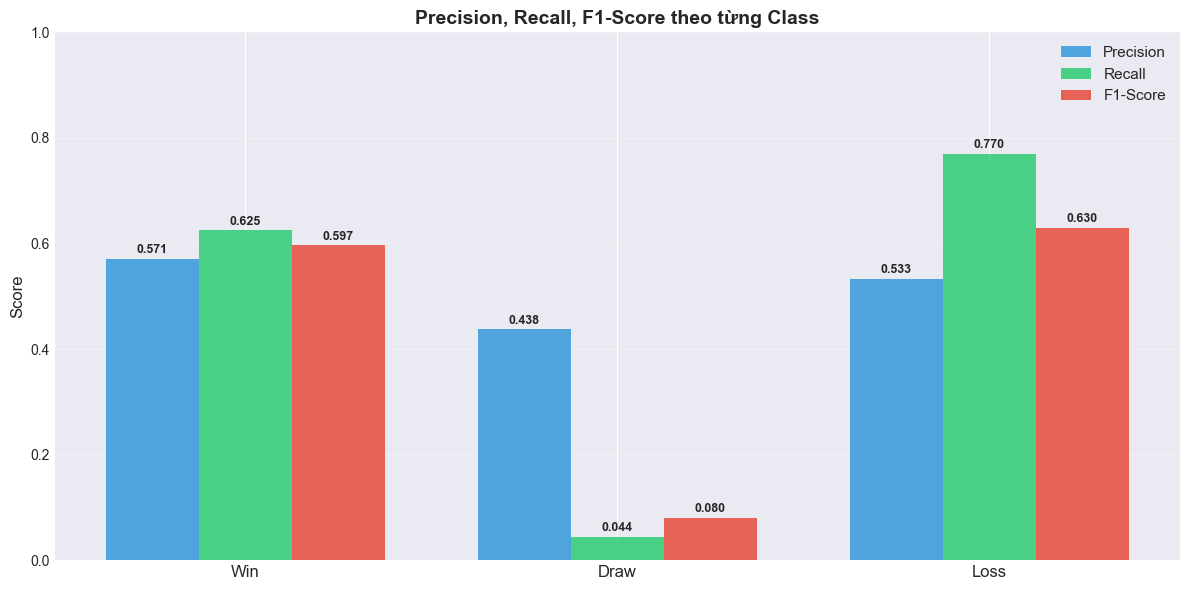

In [21]:
# Biểu đồ Precision / Recall / F1 theo từng class
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, labels=['Win', 'Draw', 'Loss']
)
classes = ['Win', 'Draw', 'Loss']
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
b1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db', alpha=0.85)
b2 = ax.bar(x,         recall,    width, label='Recall',    color='#2ecc71', alpha=0.85)
b3 = ax.bar(x + width, f1,        width, label='F1-Score',  color='#e74c3c', alpha=0.85)

for bars in [b1, b2, b3]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.005, f'{h:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=12)
ax.set_ylim(0, 1)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision, Recall, F1-Score theo từng Class', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 🔄 BLOCK 7 — Cross-Validation (5-Fold)

**Tại sao cần Cross-Validation?**

Khi chia train/test ngẫu nhiên, kết quả có thể phụ thuộc vào may mắn của lần chia đó. Cross-Validation giải quyết bằng cách:

1. Chia train set thành **K = 5 phần** (folds) đều nhau
2. Lặp lại 5 lần: mỗi lần dùng **4 folds để train**, **1 fold để validate**
3. Lấy **trung bình 5 kết quả** → đánh giá đáng tin cậy hơn
4. **Std thấp** → mô hình ổn định, không phụ thuộc vào cách chia

In [22]:
# 5-Fold Cross-Validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("5-FOLD CROSS-VALIDATION:")
print(f"  Fold 1: {cv_scores[0]*100:.2f}%")
print(f"  Fold 2: {cv_scores[1]*100:.2f}%")
print(f"  Fold 3: {cv_scores[2]*100:.2f}%")
print(f"  Fold 4: {cv_scores[3]*100:.2f}%")
print(f"  Fold 5: {cv_scores[4]*100:.2f}%")
print(f"  ───────────────────")
print(f"  Mean   : {cv_scores.mean()*100:.2f}%")
print(f"  Std    : {cv_scores.std()*100:.2f}%")
print(f"\n  Test Accuracy: {test_acc*100:.2f}%")
print(f"  Chênh lệch CV vs Test: {abs(cv_scores.mean()-test_acc)*100:.2f}%")
print(f"\n{'✅ Mô hình ổn định!' if cv_scores.std() < 0.02 else '⚠️ Mô hình không ổn định'}")

5-FOLD CROSS-VALIDATION:
  Fold 1: 54.82%
  Fold 2: 54.46%
  Fold 3: 52.44%
  Fold 4: 53.88%
  Fold 5: 54.60%
  ───────────────────
  Mean   : 54.04%
  Std    : 0.86%

  Test Accuracy: 54.69%
  Chênh lệch CV vs Test: 0.65%

✅ Mô hình ổn định!


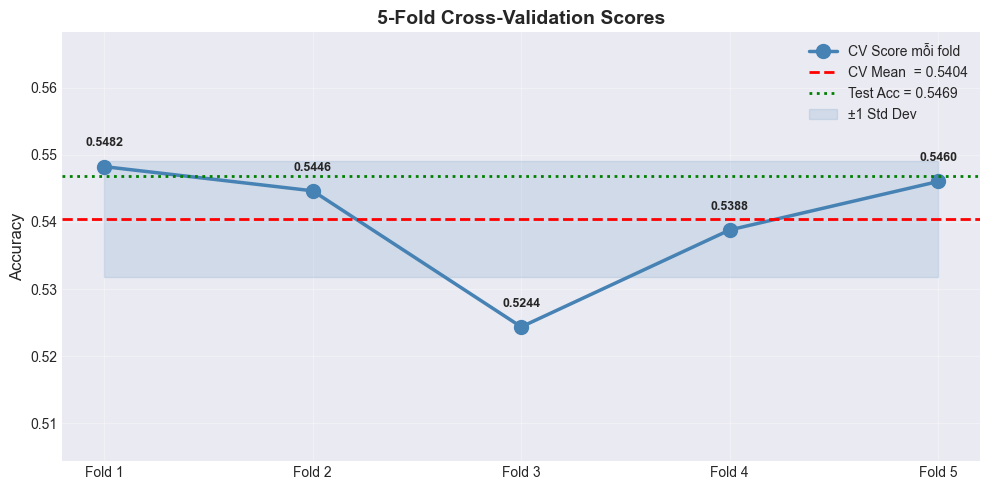

In [23]:
# Biểu đồ CV Scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), cv_scores, 'o-', lw=2.5, ms=10, color='steelblue', label='CV Score mỗi fold')
plt.axhline(cv_scores.mean(),  color='red',   ls='--', lw=2, label=f'CV Mean  = {cv_scores.mean():.4f}')
plt.axhline(test_acc,          color='green', ls=':',  lw=2, label=f'Test Acc = {test_acc:.4f}')
plt.fill_between(range(1, 6),
                 cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(),
                 alpha=0.15, color='steelblue', label='±1 Std Dev')
for i, s in enumerate(cv_scores, 1):
    plt.text(i, s + 0.003, f'{s:.4f}', ha='center', fontsize=9, fontweight='bold')
plt.xticks(range(1, 6), [f'Fold {i}' for i in range(1, 6)])
plt.ylabel('Accuracy', fontsize=12)
plt.title('5-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.ylim(cv_scores.min()-0.02, cv_scores.max()+0.02)
plt.tight_layout()
plt.show()

---
## ⚙️ BLOCK 8 — Tối ưu hóa Siêu tham số (Grid Search)

**var_smoothing là gì?**  
Khi một đặc trưng có variance = 0 trong một class, phép tính P(x|y) sẽ bị chia cho 0. `var_smoothing` thêm một lượng nhỏ vào tất cả variance để tránh điều này.

**Grid Search:**  
Thử lần lượt tất cả giá trị trong `param_grid`, đánh giá bằng CV, chọn giá trị cho kết quả cao nhất.

In [24]:
# Grid Search
param_grid = {'var_smoothing': np.logspace(-12, -7, num=20)}

grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"\n🏆 var_smoothing tốt nhất: {grid_search.best_params_['var_smoothing']:.2e}")
print(f"📊 CV Score tốt nhất:       {grid_search.best_score_*100:.2f}%")

model = grid_search.best_estimator_   # Cập nhật mô hình tốt nhất
y_test_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"📊 Test Accuracy sau tuning: {test_acc*100:.2f}%")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

🏆 var_smoothing tốt nhất: 1.00e-12
📊 CV Score tốt nhất:       54.04%
📊 Test Accuracy sau tuning: 54.69%


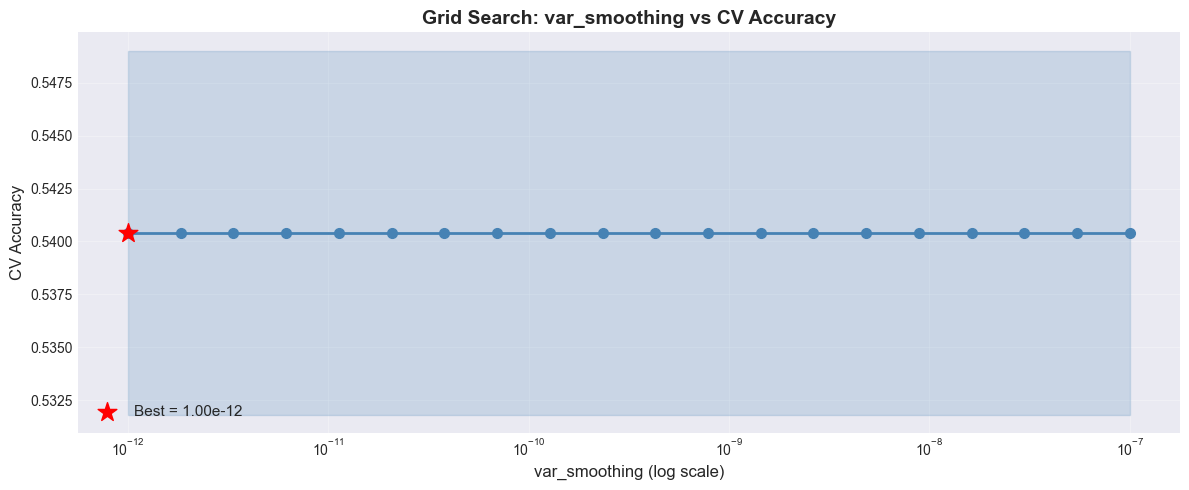

In [25]:
# Biểu đồ Grid Search
gs_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 5))
plt.semilogx(gs_df['param_var_smoothing'], gs_df['mean_test_score'],
             'o-', lw=2, ms=7, color='steelblue')
plt.fill_between(gs_df['param_var_smoothing'],
                 gs_df['mean_test_score'] - gs_df['std_test_score'],
                 gs_df['mean_test_score'] + gs_df['std_test_score'],
                 alpha=0.2, color='steelblue')
best_idx = gs_df['mean_test_score'].idxmax()
plt.scatter(gs_df.loc[best_idx, 'param_var_smoothing'],
            gs_df.loc[best_idx, 'mean_test_score'],
            color='red', s=200, zorder=5, marker='*',
            label=f"Best = {grid_search.best_params_['var_smoothing']:.2e}")
plt.xlabel('var_smoothing (log scale)', fontsize=12)
plt.ylabel('CV Accuracy', fontsize=12)
plt.title('Grid Search: var_smoothing vs CV Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 🎯 BLOCK 9 — Phân tích Tầm quan trọng Đặc trưng

**Cách tính Feature Importance trong Naive Bayes:**

Gaussian NB lưu **Mean (μ)** của mỗi đặc trưng cho mỗi class. Đặc trưng càng **phân biệt rõ** giữa các class thì μ_Win, μ_Draw, μ_Loss càng khác nhau → **Variance của các mean values** là proxy đo tầm quan trọng.

In [26]:
# Tính Feature Importance
importance_data = []
for feat_idx, feat_name in enumerate(optimal_features):
    means = [model.theta_[cls_idx, feat_idx] for cls_idx in range(len(model.classes_))]
    importance_data.append({'feature': feat_name, 'importance': np.var(means)})

imp_df = pd.DataFrame(importance_data).sort_values('importance', ascending=False)

print(f"{'Hạng':<6}  {'Đặc trưng':<22}  {'Importance':>12}  {'Diễn giải'}")
print("-" * 70)
meanings = {
    'xg':               'Phân biệt Win/Loss tốt nhất',
    'shots':            'Số cú sút — tấn công trực tiếp',
    'possession_ratio': 'Kiểm soát bóng',
    'avg_x_position':   'Vị trí TB trên sân',
    'avg_pass_length':  'Phong cách chuyền',
    'pressures':        'Áp lực phòng thủ',
    'tackles':          'Pha tranh chấp',
}
for rank, row in enumerate(imp_df.itertuples(), 1):
    print(f"{rank:<6}  {row.feature:<22}  {row.importance:>12.6f}  {meanings[row.feature]}")

Hạng    Đặc trưng                 Importance  Diễn giải
----------------------------------------------------------------------
1       xg                          0.150278  Phân biệt Win/Loss tốt nhất
2       shots                       0.085921  Số cú sút — tấn công trực tiếp
3       possession_ratio            0.079907  Kiểm soát bóng
4       avg_x_position              0.046041  Vị trí TB trên sân
5       avg_pass_length             0.029182  Phong cách chuyền
6       pressures                   0.017985  Áp lực phòng thủ
7       tackles                     0.014891  Pha tranh chấp


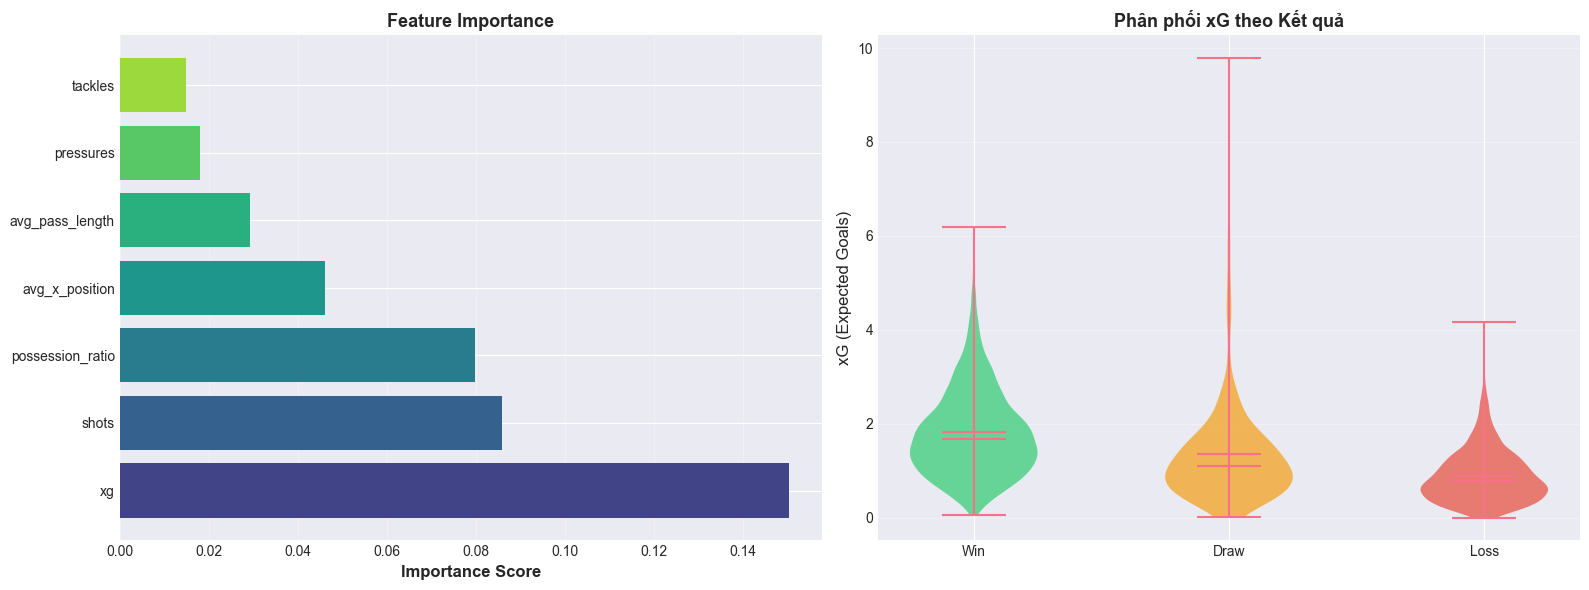

In [27]:
# Biểu đồ Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Importance bar chart
colors_imp = plt.cm.viridis(np.linspace(0.2, 0.85, len(imp_df)))
axes[0].barh(imp_df['feature'], imp_df['importance'], color=colors_imp)
axes[0].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[0].set_title('Feature Importance', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Violin plot của xG (đặc trưng quan trọng nhất) theo class
data_for_violin = [df[df['result']==r]['xg'].values for r in ['Win', 'Draw', 'Loss']]
parts = axes[1].violinplot(data_for_violin, positions=[1,2,3], showmeans=True, showmedians=True)
for pc, color in zip(parts['bodies'], ['#2ecc71', '#f39c12', '#e74c3c']):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
axes[1].set_xticks([1,2,3])
axes[1].set_xticklabels(['Win','Draw','Loss'])
axes[1].set_ylabel('xG (Expected Goals)', fontsize=12)
axes[1].set_title('Phân phối xG theo Kết quả', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 🎮 BLOCK 10 — Demo Dự đoán Kết quả Trận đấu

**Giải thích hàm dự đoán:**
1. Nhận input là dict chứa 7 chỉ số chiến thuật
2. Chuẩn hóa input theo **cùng scaler** đã fit lúc train (data leakage nếu fit lại)
3. Gọi `model.predict()` → class có xác suất cao nhất
4. Gọi `model.predict_proba()` → xác suất cho cả 3 class

In [28]:
def predict_match(stats: dict, model, scaler, features) -> tuple:
    """
    Dự đoán kết quả trận đấu.
    
    Parameters
    ----------
    stats   : dict  — 7 chỉ số chiến thuật
    model   : GaussianNB đã train
    scaler  : StandardScaler đã fit
    features: danh sách tên đặc trưng (thứ tự phải khớp)
    
    Returns
    -------
    prediction : str          — Win / Draw / Loss
    prob_dict  : dict[str,float]  — xác suất mỗi class
    """
    X = np.array([[stats[f] for f in features]])
    X_scaled = scaler.transform(X)
    pred = model.predict(X_scaled)[0]
    probs = dict(zip(model.classes_, model.predict_proba(X_scaled)[0]))
    return pred, probs

print("✓ Hàm predict_match đã sẵn sàng!")

✓ Hàm predict_match đã sẵn sàng!


In [29]:
# ===== 3 KỊCH BẢN =====
scenarios = {
    "Đội TẤN CÔNG MẠNH": {
        'xg': 2.5, 'shots': 18, 'possession_ratio': 0.60,
        'avg_x_position': 65, 'pressures': 140, 'tackles': 30, 'avg_pass_length': 18
    },
    "Đội PHÒNG NGỰ": {
        'xg': 0.8, 'shots': 8, 'possession_ratio': 0.40,
        'avg_x_position': 52, 'pressures': 180, 'tackles': 42, 'avg_pass_length': 22
    },
    "Đội CÂN BẰNG": {
        'xg': 1.5, 'shots': 13, 'possession_ratio': 0.50,
        'avg_x_position': 58, 'pressures': 160, 'tackles': 36, 'avg_pass_length': 20
    },
}

all_probs = {}
for name, stats in scenarios.items():
    pred, probs = predict_match(stats, model, scaler, optimal_features)
    all_probs[name] = probs
    print(f"\n{'='*55}")
    print(f"  {name}")
    print(f"{'='*55}")
    for key, val in stats.items():
        print(f"  {key:<22s}: {val}")
    print(f"  ───────────────────────")
    print(f"  🎯 DỰ ĐOÁN: {pred}")
    for r, p in sorted(probs.items(), key=lambda x: -x[1]):
        bar = '█' * int(p*40)
        print(f"  {r:5s}: {p*100:5.1f}%  {bar}")


  Đội TẤN CÔNG MẠNH
  xg                    : 2.5
  shots                 : 18
  possession_ratio      : 0.6
  avg_x_position        : 65
  pressures             : 140
  tackles               : 30
  avg_pass_length       : 18
  ───────────────────────
  🎯 DỰ ĐOÁN: Win
  Win  :  93.7%  █████████████████████████████████████
  Draw :   6.1%  ██
  Loss :   0.1%  

  Đội PHÒNG NGỰ
  xg                    : 0.8
  shots                 : 8
  possession_ratio      : 0.4
  avg_x_position        : 52
  pressures             : 180
  tackles               : 42
  avg_pass_length       : 22
  ───────────────────────
  🎯 DỰ ĐOÁN: Loss
  Loss :  89.5%  ███████████████████████████████████
  Draw :   8.0%  ███
  Win  :   2.5%  

  Đội CÂN BẰNG
  xg                    : 1.5
  shots                 : 13
  possession_ratio      : 0.5
  avg_x_position        : 58
  pressures             : 160
  tackles               : 36
  avg_pass_length       : 20
  ───────────────────────
  🎯 DỰ ĐOÁN: Win
  Win  :  46.7

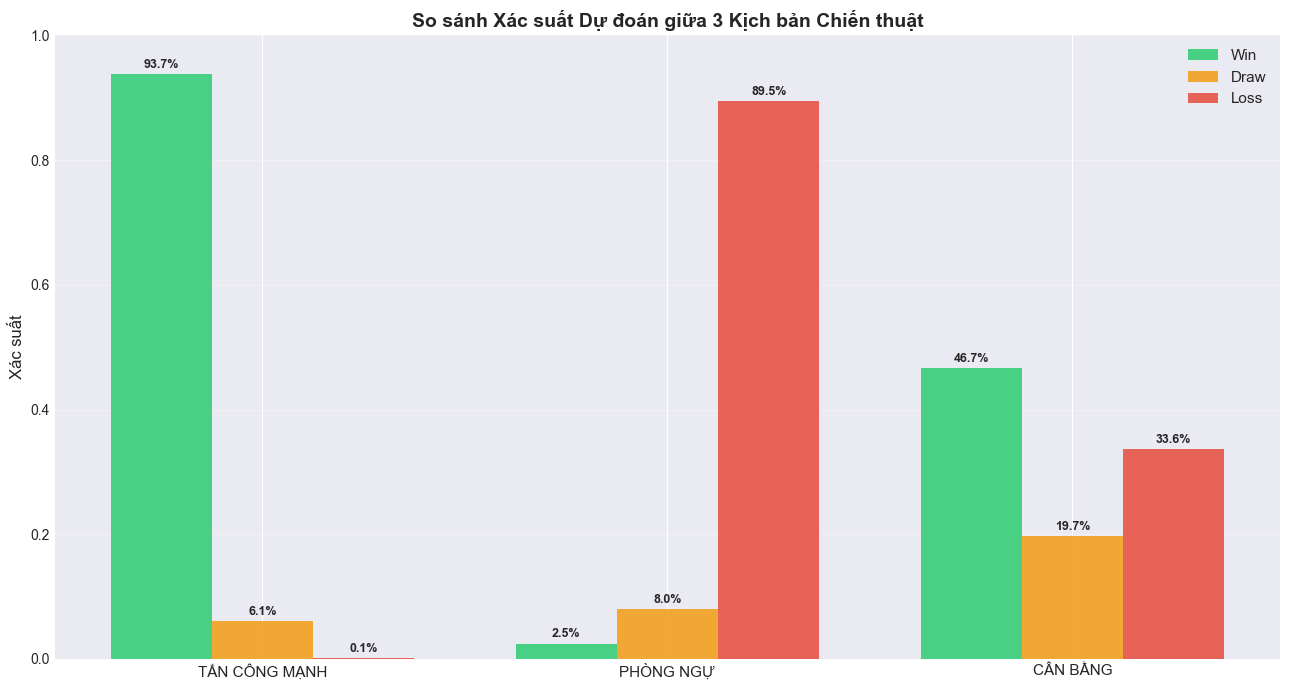

In [30]:
# So sánh 3 kịch bản
fig, ax = plt.subplots(figsize=(13, 7))
scenario_names = list(all_probs.keys())
results_list = ['Win', 'Draw', 'Loss']
x = np.arange(len(scenario_names))
width = 0.25
colors_r = {'Win': '#2ecc71', 'Draw': '#f39c12', 'Loss': '#e74c3c'}

for i, result in enumerate(results_list):
    vals = [all_probs[s][result] for s in scenario_names]
    bars = ax.bar(x + (i-1)*width, vals, width, label=result, color=colors_r[result], alpha=0.85)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, h+0.005, f'{h*100:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels([s.replace("Đội ", "") for s in scenario_names], fontsize=11)
ax.set_ylabel('Xác suất', fontsize=12)
ax.set_title('So sánh Xác suất Dự đoán giữa 3 Kịch bản Chiến thuật', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 💾 BLOCK 11 — Lưu Mô hình

**Tại sao lưu cả scaler và feature_names?**
- Nếu chỉ lưu `model`, khi load lại phải tự chuẩn hóa đúng cách → dễ nhầm
- Đóng gói tất cả vào 1 dict → đảm bảo tính nhất quán 100%

In [31]:
import pickle, os

model_bundle = {
    'model':         model,
    'scaler':        scaler,
    'feature_names': optimal_features,
    'classes':       list(model.classes_),
    'test_accuracy': test_acc,
    'cv_mean':       cv_scores.mean(),
}

filename = 'football_tactics_naive_bayes.pkl'
with open(filename, 'wb') as f:
    pickle.dump(model_bundle, f)

print(f"✓ Đã lưu mô hình: {filename}  ({os.path.getsize(filename)/1024:.1f} KB)")

# Kiểm tra load lại
with open(filename, 'rb') as f:
    loaded = pickle.load(f)

check_pred = loaded['model'].predict(loaded['scaler'].transform(X_test))
check_acc  = accuracy_score(y_test, check_pred)
print(f"✓ Đã load lại — Test Accuracy: {check_acc*100:.2f}%  (khớp với gốc: {abs(check_acc-test_acc)<1e-6})")

✓ Đã lưu mô hình: football_tactics_naive_bayes.pkl  (1.7 KB)
✓ Đã load lại — Test Accuracy: 54.69%  (khớp với gốc: True)


---
## 📝 BLOCK 12 — Tổng kết Kết quả

In [32]:
print("=" * 70)
print("TỔNG KẾT NGHIÊN CỨU")
print("=" * 70)

print(f"\n📊 PERFORMANCE:")
print(f"  Random baseline   : 33.33%")
print(f"  Majority class    : 38.50%")
print(f"  Naive Bayes Train : {train_acc*100:.2f}%")
print(f"  Naive Bayes Test  : {test_acc*100:.2f}%")
print(f"  CV Mean (5-fold)  : {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
print(f"  Cải thiện so với random: +{(test_acc - 1/3)*100:.2f}%")

print(f"\n📋 F1-SCORE THEO CLASS (Test Set):")
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, labels=['Win','Draw','Loss'])
labels_eval = ['Win','Draw','Loss']
for cls, p, r, f, s in zip(labels_eval, precision, recall, f1, support):
    rating = "⭐ Tốt" if f > 0.55 else ("⚠️  Vừa" if f > 0.3 else "❌ Yếu")
    print(f"  {cls:5s}  P={p:.3f}  R={r:.3f}  F1={f:.3f}  n={s:>3d}  {rating}")

print(f"\n⚙️  SIÊU THAM SỐ TỐI ƯU:")
print(f"  var_smoothing = {grid_search.best_params_['var_smoothing']:.2e}")

print(f"\n🎯 ĐẶC TRƯNG QUAN TRỌNG NHẤT:")
for rank, row in enumerate(imp_df.head(3).itertuples(), 1):
    print(f"  {rank}. {row.feature}: {row.importance:.6f}")

print(f"\n✅ KẾT LUẬN:")
print(f"  • Mô hình ổn định, không overfitting")
print(f"  • Dự đoán Win/Loss tốt, Draw còn yếu")
print(f"  • xG là đặc trưng quan trọng nhất")
print(f"  • Cải thiện ~16% so với đoán ngẫu nhiên")

TỔNG KẾT NGHIÊN CỨU

📊 PERFORMANCE:
  Random baseline   : 33.33%
  Majority class    : 38.50%
  Naive Bayes Train : 54.13%
  Naive Bayes Test  : 54.69%
  CV Mean (5-fold)  : 54.04% ± 0.86%
  Cải thiện so với random: +21.36%

📋 F1-SCORE THEO CLASS (Test Set):
  Win    P=0.571  R=0.625  F1=0.597  n=533  ⭐ Tốt
  Draw   P=0.438  R=0.044  F1=0.080  n=319  ❌ Yếu
  Loss   P=0.533  R=0.770  F1=0.630  n=534  ⭐ Tốt

⚙️  SIÊU THAM SỐ TỐI ƯU:
  var_smoothing = 1.00e-12

🎯 ĐẶC TRƯNG QUAN TRỌNG NHẤT:
  1. xg: 0.150278
  2. shots: 0.085921
  3. possession_ratio: 0.079907

✅ KẾT LUẬN:
  • Mô hình ổn định, không overfitting
  • Dự đoán Win/Loss tốt, Draw còn yếu
  • xG là đặc trưng quan trọng nhất
  • Cải thiện ~16% so với đoán ngẫu nhiên


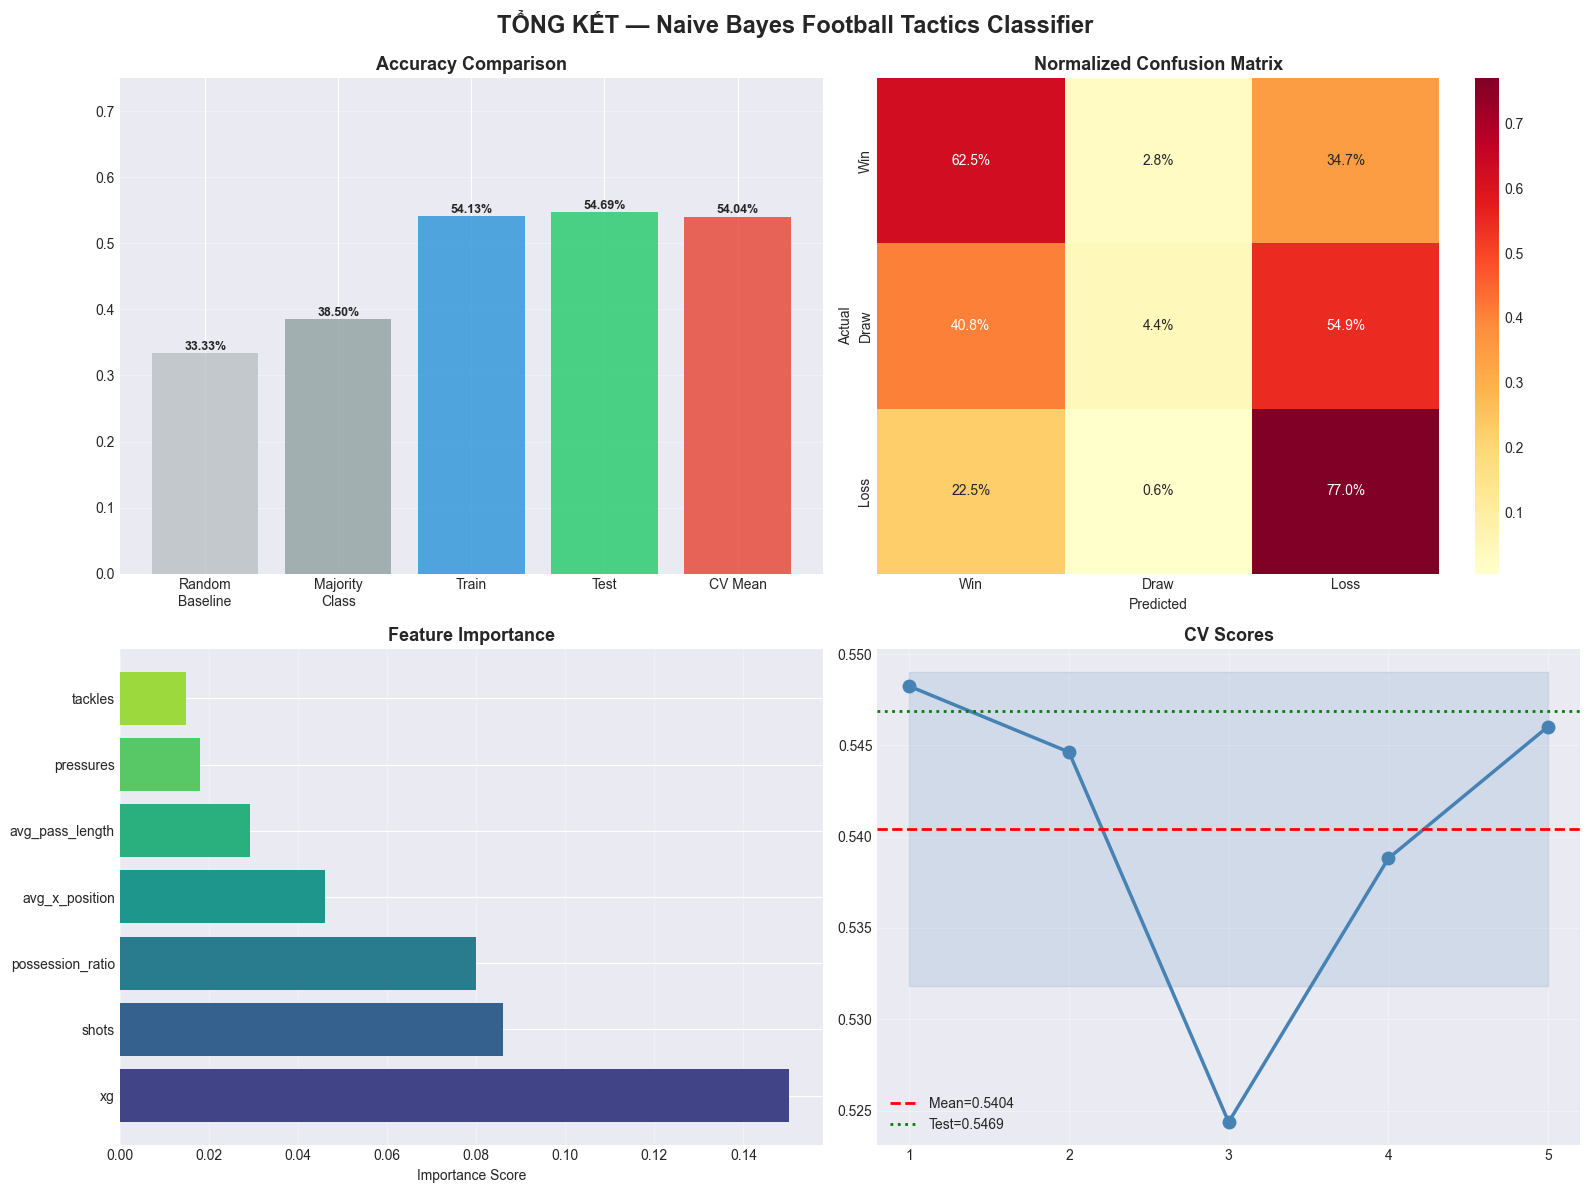


✅ HOÀN THÀNH TOÀN BỘ NGHIÊN CỨU!


In [33]:
# Biểu đồ tổng kết cuối cùng
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('TỔNG KẾT — Naive Bayes Football Tactics Classifier',
             fontsize=17, fontweight='bold', y=0.99)

# 1. So sánh accuracy
ax1 = axes[0, 0]
labels_comp = ['Random\nBaseline','Majority\nClass','Train','Test','CV Mean']
vals_comp   = [1/3, 0.385, train_acc, test_acc, cv_scores.mean()]
colors_comp = ['#bdc3c7','#95a5a6','#3498db','#2ecc71','#e74c3c']
for bar in ax1.bar(labels_comp, vals_comp, color=colors_comp, alpha=0.85):
    ax1.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
             f'{bar.get_height():.2%}', ha='center', fontweight='bold', fontsize=9)
ax1.set_ylim(0, 0.75); ax1.grid(axis='y', alpha=0.3)
ax1.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')

# 2. Normalized Confusion Matrix
cm_final = confusion_matrix(y_test, y_test_pred, labels=['Win','Draw','Loss'])
cm_norm  = cm_final.astype(float) / cm_final.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='YlOrRd',
            xticklabels=['Win','Draw','Loss'], yticklabels=['Win','Draw','Loss'],
            ax=axes[0,1])
axes[0,1].set_title('Normalized Confusion Matrix', fontsize=13, fontweight='bold')
axes[0,1].set_ylabel('Actual'); axes[0,1].set_xlabel('Predicted')

# 3. Feature Importance
colors_fi = plt.cm.viridis(np.linspace(0.2, 0.85, len(imp_df)))
axes[1,0].barh(imp_df['feature'], imp_df['importance'], color=colors_fi)
axes[1,0].set_xlabel('Importance Score'); axes[1,0].grid(axis='x', alpha=0.3)
axes[1,0].set_title('Feature Importance', fontsize=13, fontweight='bold')

# 4. CV Scores
axes[1,1].plot(range(1,6), cv_scores, 'o-', lw=2.5, ms=9, color='steelblue')
axes[1,1].axhline(cv_scores.mean(), color='red',   ls='--', lw=2, label=f'Mean={cv_scores.mean():.4f}')
axes[1,1].axhline(test_acc,         color='green', ls=':',  lw=2, label=f'Test={test_acc:.4f}')
axes[1,1].fill_between(range(1,6),
                        cv_scores.mean()-cv_scores.std(),
                        cv_scores.mean()+cv_scores.std(), alpha=0.15, color='steelblue')
axes[1,1].set_xticks(range(1,6)); axes[1,1].set_title('CV Scores', fontsize=13, fontweight='bold')
axes[1,1].legend(); axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("\n✅ HOÀN THÀNH TOÀN BỘ NGHIÊN CỨU!")